In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import tensorflow as tf
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, FastText
from gensim.parsing.preprocessing import remove_stopwords
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
#from keras.layers import Embedding, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_dataset():

    # Load train data
    train = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_train.csv', encoding = "ISO-8859-1")

    # Load test data
    test = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_test.csv', encoding = "ISO-8859-1")

    return train, test


In [ ]:
train, test = load_dataset()

validation = pd.DataFrame(columns=train.columns)
split_by_class = train.groupby('Sentiment')

for group, data in split_by_class:
  split = data.sample(frac=0.2, random_state=200)
  validation = validation.append(split, ignore_index=True)
  train = train.drop(split.index.values.tolist())


num_label_train = train['Sentiment'].value_counts()
num_label_validation = validation['Sentiment'].value_counts()
num_label_test = test['Sentiment'].value_counts()


**Plot distribution of the classes in train set and test set**

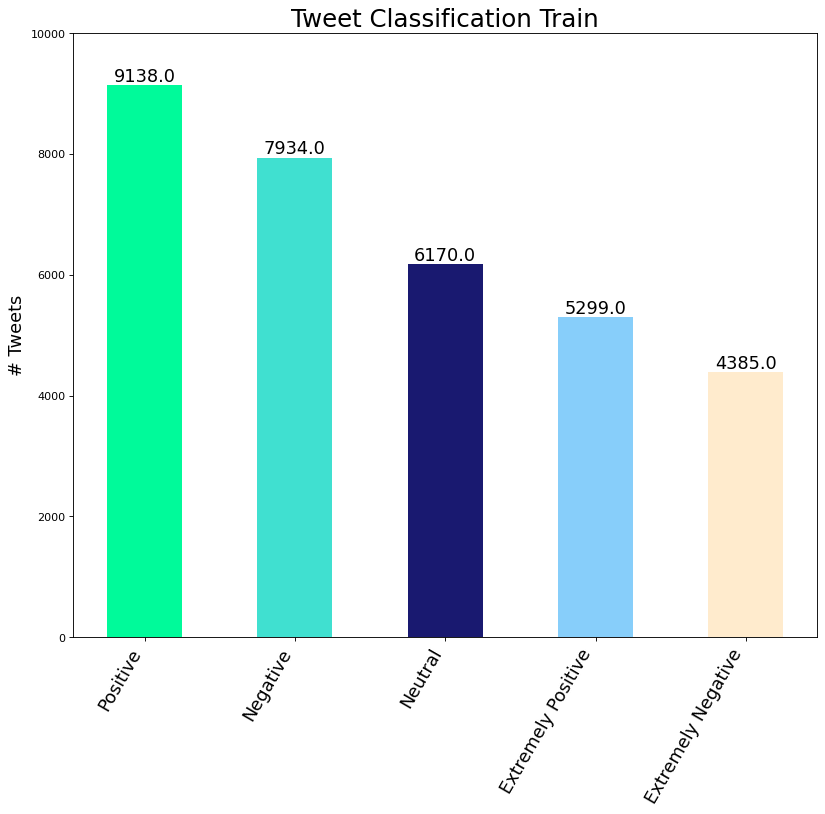

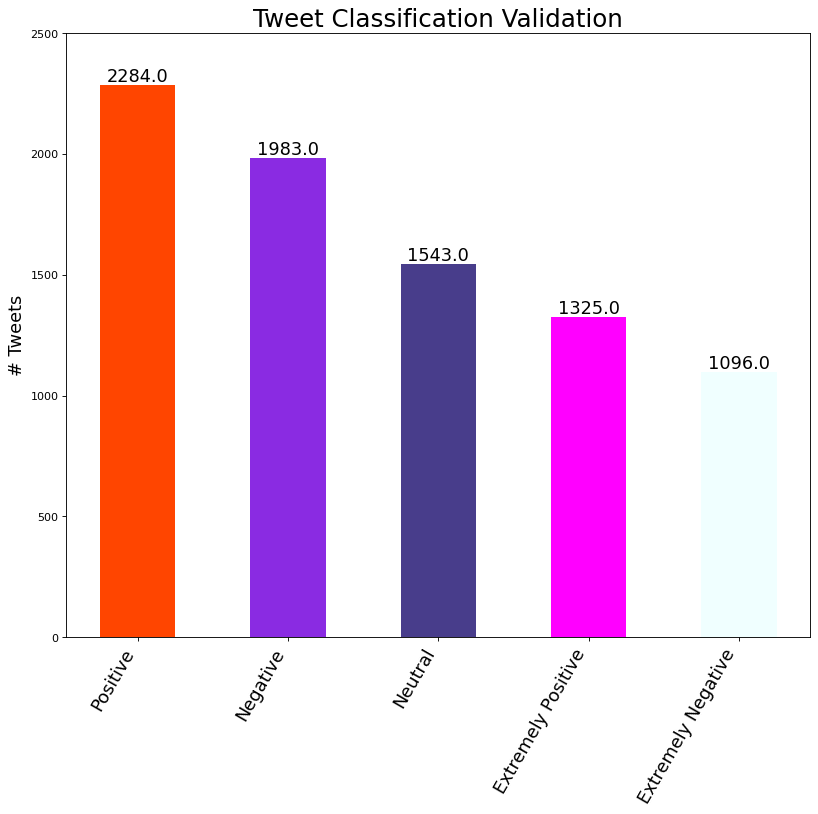

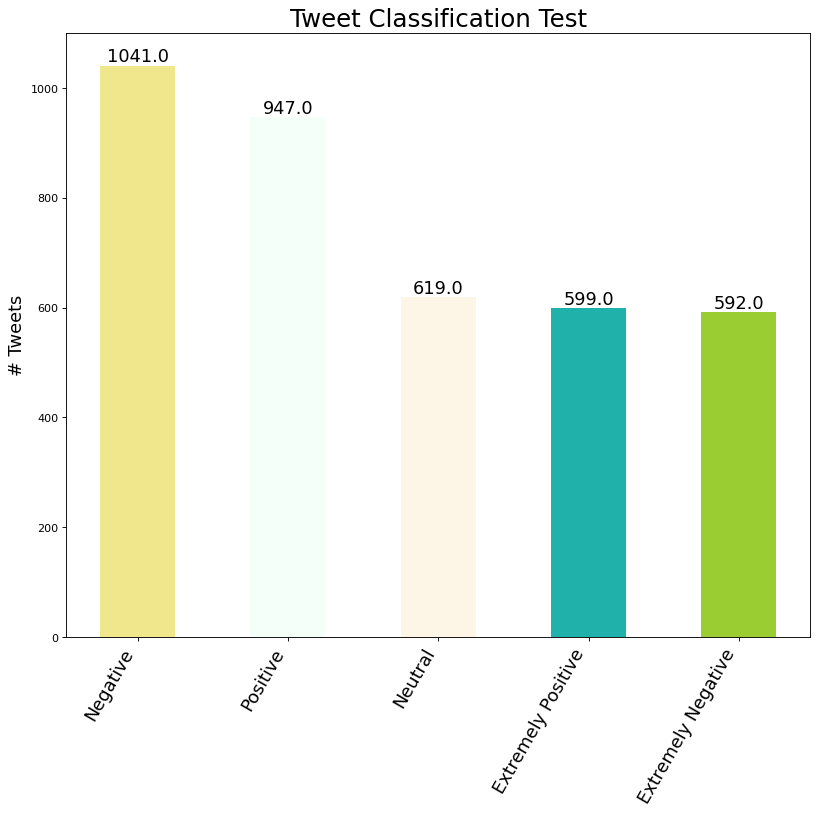

In [ ]:
def plot_class_dist(labels, tweets, title, max_item):
  
  all_colors = list(plt.cm.colors.cnames.keys())
  c = np.random.choice(all_colors, 6)

  plt.figure(figsize=(12,10), dpi= 80)

  plt.bar(labels, tweets, color=c, width=.5)
  for i, val in enumerate(tweets):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
  plt.title(title, fontsize=22)
  plt.gca().set_xticklabels(labels, rotation=60, horizontalalignment= 'right', fontsize=16)
  plt.ylabel('# Tweets', fontsize=16)
  plt.ylim(0, max_item)
  plt.show()

plot_class_dist(num_label_train.index, num_label_train.values, "Tweet Classification Train", 10000)
plot_class_dist(num_label_validation.index, num_label_validation.values, "Tweet Classification Validation", 2500)
plot_class_dist(num_label_test.index, num_label_test.values, "Tweet Classification Test", 1100)


**Plot number of words in the tweets**

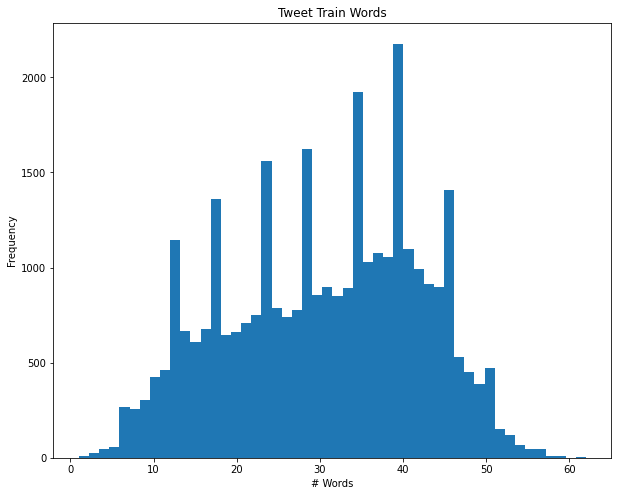

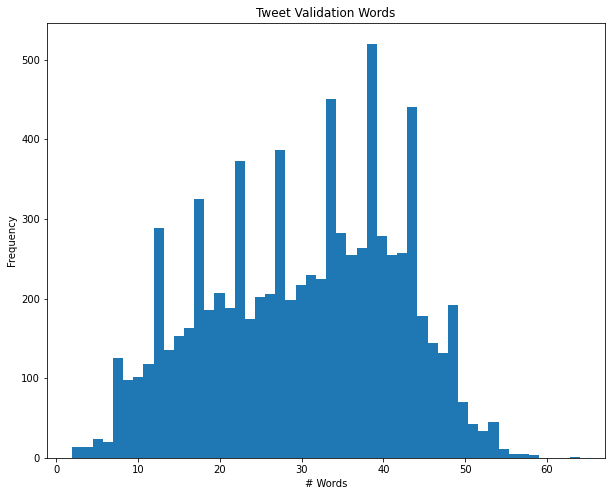

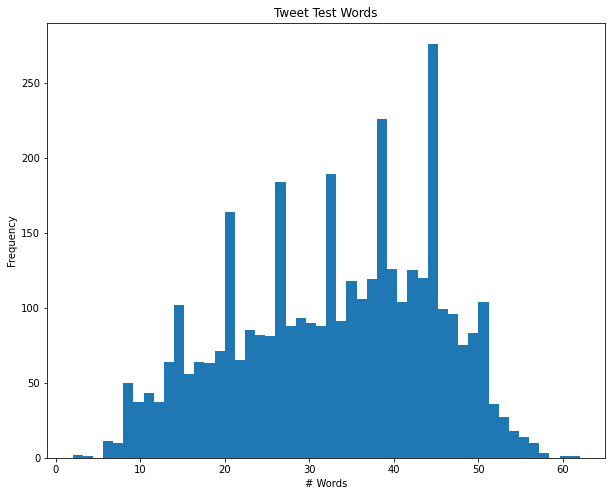

In [ ]:
train['TotalWords'] = train['OriginalTweet'].str.lower().str.split().apply(len)
validation['TotalWords'] = validation['OriginalTweet'].str.lower().str.split().apply(len)
test['TotalWords'] = test['OriginalTweet'].str.lower().str.split().apply(len)

train['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Train Words").set_xlabel("# Words")
plt.show()

validation['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Validation Words").set_xlabel("# Words")
plt.show()

test['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Test Words").set_xlabel("# Words")
plt.show()


**Pre-Processing**

In [ ]:
def pre_processing(df):

  # Remove URL from text
  df['NoURL'] = df['OriginalTweet'].str.replace('http\S+|www.\S+', '', case=False)

  # Remove Tag from text
  df['NoTag'] = df['NoURL'].str.replace('@\S+', '', case=False)

  # Remove punctation from text
  df['NoPunct'] = df['NoTag'].str.translate(str.maketrans('', '', string.punctuation))

  return df


def remove_stop_words(df):
  df['NoStopWords'] = df['NoPunct'].apply(lambda x: remove_stopwords(str(x)))
  df['NoStopWords'].replace('', np.nan, inplace=True)
  df.dropna(subset=['NoStopWords'], inplace=True)
  return df

train = pre_processing(train)
train = remove_stop_words(train)
train['Words'] = train['NoStopWords'].str.split(' ')


num_label_train = train['Sentiment'].value_counts()


Word2Vec(vocab=66868, size=5, alpha=0.025)
['advice', 'Talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'schools', 'employer', 'chemist', 'GP', 'set', 'online', 'shopping', 'accounts', 'poss', 'adequate', 'supplies', 'regular', 'meds', 'order', 'Coronavirus', 'Australia', 'Woolworths', 'elderly', 'disabled', 'dedicated', 'hours', 'amid', 'COVID19', 'outbreak', 'My', 'food', 'stock', 'PLEASE', 'dont', 'panic', 'THERE', 'WILL', 'BE', 'ENOUGH', 'FOOD', 'FOR', 'EVERYONE', 'need', 'Stay', 'calm', 'stay', 'safe', 'COVID19france', 'coronavirus', 'confinement', 'Confinementotal', 'ConfinementGeneral', 'Me', 'ready', 'supermarket', 'Not', 'Im', 'paranoid', 'litteraly', 'The', 'thing', 'It', 'causes', 'shortage', 'CoronavirusFrance', 'restezchezvous', 'StayAtHome', 'As', 'news', 'regionÂ\x92s', 'confirmed', 'case', 'came', 'Sullivan', 'County', 'week', 'people', 'flocked', 'area', 'stores', 'purchase', 'cleaning', 'hand', 'sanitizer', 'toilet', 'paper',

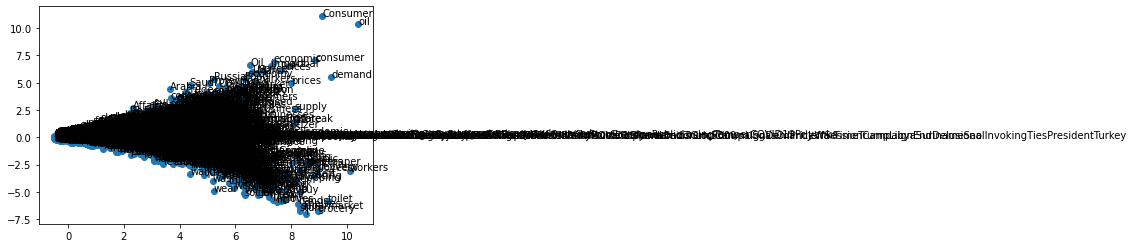

In [ ]:
# train word2vec model
w2v = Word2Vec(train['Words'], min_count=1, size = 5)
print(w2v)

#list the vocabulary words
words = list(w2v.wv.vocab)
print(words)
#or show the dictionary of vocab words
w2v.wv.vocab

X = w2v[w2v.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = list(w2v.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()


**GloVe word-embeddings**

In [ ]:
num_train = num_label_train.sum()
labels = pd.factorize(train.Sentiment)[0]

train.NoStopWords = train.NoStopWords.astype('unicode')
data = np.array(train.NoStopWords.values)

#print(data.dtype)
#print(data)
#print(type(data[0]))

cutoff = 32904
y_train, y_val = labels[:cutoff], labels[cutoff:]
x_train, x_val = data[:cutoff], data[cutoff:]

print(x_train)
print(type(x_train[0]))

'''
x_train =  data[:int(num_train*0.8)]
y_train = labels[:int(num_train*0.8)]
x_val =  data[int(num_train*0.8):]
y_val = labels[int(num_train*0.8):]

glove_dir = '/Users/fchollet/Downloads/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector



model = Sequential()
model.add(Embedding(1000, 100, input_length=1))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

#model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))
#model.save_weights('pre_trained_glove_model.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

'''

['advice Talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist GP set online shopping accounts poss adequate supplies regular meds order'
 'Coronavirus Australia Woolworths elderly disabled dedicated shopping hours amid COVID19 outbreak'
 'My food stock PLEASE dont panic THERE WILL BE ENOUGH FOOD FOR EVERYONE need Stay calm stay safe COVID19france COVID19 COVID19 coronavirus confinement Confinementotal ConfinementGeneral'
 ...
 'The weapon digital warriors fight COVID19 Cabo Verde directory tech solutions types needshome delivery online shoppingamppayments Made community M CaboVerde Africa Covid19'
 'Please join Complimentary Webinar Credit Reporting COVID 19 Guidance Consumer Financial Service Companies Reporting Consumer Credit During Pandemic Thursday April 9 2020 4 00 5 00 p m ET'
 'New Offers Lower Prices Financing COVID19 Update']
<class 'str'>


"\nx_train =  data[:int(num_train*0.8)]\ny_train = labels[:int(num_train*0.8)]\nx_val =  data[int(num_train*0.8):]\ny_val = labels[int(num_train*0.8):]\n\nglove_dir = '/Users/fchollet/Downloads/glove.6B'\nembeddings_index = {}\nf = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))\n\nfor line in f:\n  values = line.split()\n  word = values[0]\n  coefs = np.asarray(values[1:], dtype='float32')\n  embeddings_index[word] = coefs\nf.close()\n\nprint('Found %s word vectors.' % len(embeddings_index))\n\nembedding_dim = 100\nembedding_matrix = np.zeros((max_words, embedding_dim))\n\nfor word, i in word_index.items():\n  if i < max_words:\n    embedding_vector = embeddings_index.get(word)\n    if embedding_vector is not None:\n      embedding_matrix[i] = embedding_vector\n\n\n\nmodel = Sequential()\nmodel.add(Embedding(1000, 100, input_length=1))\nmodel.add(Flatten())\nmodel.add(Dense(32, activation='relu'))\nmodel.add(Dense(1, activation='sigmoid'))\nmodel.summary()\n\n#model.layers[0].set_w

In [ ]:
# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=tf.strings.regex_replace(data, '', ''),
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

embedding_dim=16

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[tensorboard_callback])

ValueError: ignored